Name: Karthik Venugopal

USC ID: 9330529336

github username: Karthikvenugopal

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.metrics import classification_report

In [3]:
base_dir = "SeparatedWaste"
img_height, img_width = 224, 224
batch_size = 5
epochs = 100

dirs = {name: os.path.join(base_dir, name) for name in ["train", "val", "test"]}

preprocess_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

train_gen = preprocess_gen.flow_from_directory(
    dirs["train"], target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', shuffle=True
)
val_gen = preprocess_gen.flow_from_directory(
    dirs["val"], target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', shuffle=False
)
test_gen = preprocess_gen.flow_from_directory(
    dirs["test"], target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', shuffle=False
)

Found 3323 images belonging to 9 classes.
Found 710 images belonging to 9 classes.
Found 719 images belonging to 9 classes.


In [4]:
base_model = ResNet101(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False

def build_top_layers(base_output, num_classes):
    x = GlobalAveragePooling2D()(base_output)
    for units in [256, 128, 64]:
        x = Dense(units, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        if units == 128:
            x = Dropout(0.2)(x)
    return Dense(num_classes, activation='softmax')(x)

output = build_top_layers(base_model.output, train_gen.num_classes)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=40,
    restore_best_weights=True
)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


665/665 ━━━━━━━━━━━━━━━━━━━━ 211s 312ms/step - accuracy: 0.2352 - loss: 9.2856 - val_accuracy: 0.5254 - val_loss: 8.2325
Epoch 2/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 219s 330ms/step - accuracy: 0.4749 - loss: 8.1972 - val_accuracy: 0.6127 - val_loss: 7.5639
Epoch 3/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 224s 336ms/step - accuracy: 0.5419 - loss: 7.7203 - val_accuracy: 0.6718 - val_loss: 7.1256
Epoch 4/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 226s 340ms/step - accuracy: 0.5627 - loss: 7.3320 - val_accuracy: 0.6958 - val_loss: 6.7144
Epoch 5/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 224s 336ms/step - accuracy: 0.6311 - loss: 6.8373 - val_accuracy: 0.7056 - val_loss: 6.3389
Epoch 6/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 260s 392ms/step - accuracy: 0.6219 - loss: 6.5139 - val_accuracy: 0.7028 - val_loss: 6.0555
Epoch 7/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 232s 348ms/step - accuracy: 0.6451 - loss: 6.1074 - val_accuracy: 0.7225 - val_loss: 5.6381
Epoch 8/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 258s 388ms/step - accuracy: 0.6766 - los

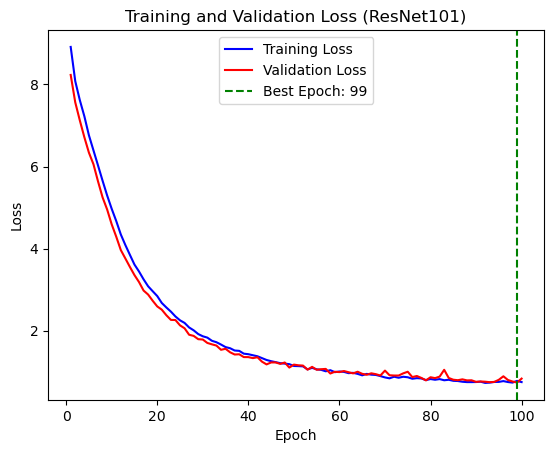

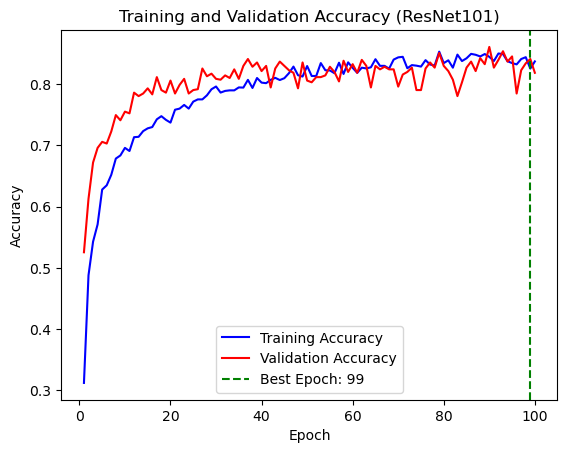

In [6]:
history_df = pd.DataFrame(history.history)
best_epoch = history_df['val_loss'].idxmin() + 1
epoch_range = np.arange(1, len(history_df) + 1)

def plot_metric(metric, ylabel, title):
    plt.figure()
    plt.plot(epoch_range, history_df[metric], 'b', label=f'Training {ylabel}')
    plt.plot(epoch_range, history_df[f'val_{metric}'], 'r', label=f'Validation {ylabel}')
    plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Epoch: {best_epoch}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot_metric('loss', 'Loss', 'Training and Validation Loss (ResNet101)')
plot_metric('accuracy', 'Accuracy', 'Training and Validation Accuracy (ResNet101)')


In [7]:
y_test_probs = model.predict(test_gen, verbose=0)
y_test_preds = np.argmax(y_test_probs, axis=1)
y_test_true = test_gen.classes
class_names = [f"{i+1}-{name}" for i, name in enumerate(test_gen.class_indices)]

report_dict = classification_report(
    y_test_true, y_test_preds, target_names=class_names, output_dict=True
)
report_df = pd.DataFrame(report_dict).T.round(2)
summary = ['accuracy', 'macro avg', 'weighted avg']
classes = [idx for idx in report_df.index if idx not in summary]
report_df = report_df.loc[classes + summary]

print("\n Classification Report for ResNet101 on Test Set:\n")
print(report_df.to_string())

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



 Classification Report for ResNet101 on Test Set:

                         precision  recall  f1-score  support
1-1-Cardboard                 0.79    0.83      0.81    70.00
2-2-Food Organics             0.95    0.84      0.89    63.00
3-3-Glass                     0.91    0.84      0.88    63.00
4-4-Metal                     0.86    0.82      0.84   119.00
5-5-Miscellaneous Trash       0.80    0.69      0.74    75.00
6-6-Paper                     0.79    0.96      0.87    75.00
7-7-Plastic                   0.81    0.81      0.81   139.00
8-8-Textile Trash             0.81    0.86      0.83    49.00
9-9-Vegetation                0.92    1.00      0.96    66.00
accuracy                      0.84    0.84      0.84     0.84
macro avg                     0.85    0.85      0.85   719.00
weighted avg                  0.84    0.84      0.84   719.00


In [8]:
model.save('Final_Resnet101_model.keras')